In [ ]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import datetime as dt

from factor_momentum import assetspace_signal_monthly

from sf_quant.data import load_factors

In [2]:
TYPE = '1m cross-section'

In [3]:
start = dt.date(2000,1,1)
end = dt.date(2020,1,1)

monthly_signal = assetspace_signal_monthly(start=start, end=end, type=TYPE)
monthly_signal

month,barrid,ret,specific_risk,market_cap,signal
date,str,f64,f64,f64,f64
2013-07-01,"""USA06Z1""",-0.001596,55.056916,6.006157e8,5.196
2013-08-01,"""USA06Z1""",-0.014481,54.406366,5.9463375e8,4.225545
2013-09-01,"""USA06Z1""",-0.391781,57.884562,4.0188375e8,3.6733
2013-10-01,"""USA06Z1""",0.23979,58.065759,5.174708e8,0.385174
2013-11-01,"""USA06Z1""",0.172845,57.269027,6.071625e8,2.7862
…,…,…,…,…,…
2019-12-01,"""USBEVY1""",0.038019,77.098934,6.0276e8,11.343
2019-12-01,"""USBEWD1""",0.007976,67.137569,2.0000e8,9.996
2019-12-01,"""USBEWE1""",-0.030714,62.962481,3.6251e8,14.077


In [4]:
monthly_signal = (monthly_signal.with_columns(
    (pl.col('ret') * pl.col('market_cap')/pl.col('market_cap').sum().over('month')).alias('wret')
)
)

In [5]:
benchmark = monthly_signal.group_by(['month']).agg(
    pl.col('wret').mean()
).sort('month')

benchmark

month,wret
date,f64
2000-01-01,-0.000012
2000-02-01,0.000012
2000-03-01,0.00003
2000-04-01,-0.000011
2000-05-01,-0.000008
…,…
2019-08-01,-0.000006
2019-09-01,0.000006
2019-10-01,0.000008


In [6]:
binned = (monthly_signal.with_columns(
    pl.col('signal').rank('dense').over('month').alias('rank')
)
.with_columns(
    (pl.lit("p") +
    (pl.col('rank')/pl.col('rank').count().over('month')*10 - 0.0001)
    .floor()
    .cast(pl.Int32).cast(pl.Utf8))
    .alias('bin')
)
.group_by(['month', 'bin']).agg(
    pl.col('ret').mean().alias('ret'),
    pl.col('wret').count().alias('count'),
    pl.col('market_cap').sum()
)
.sort(['bin', 'month'])
.with_columns(
    (pl.col('ret') * pl.col('market_cap') / pl.col('market_cap').sum().over('month')).alias('wret')
)
)

ports_ew = (binned
.pivot(on='bin', index='month', values='ret')
.drop_nulls()
)

ports_vw = (binned
.pivot(on='bin', index='month', values='wret')
.drop_nulls()
)

ports_vw

month,p0,p1,p2,p3,p4,p5,p6,p7,p8,p9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2000-01-01,-0.009333,-0.007664,-0.008751,-0.006873,-0.006046,-0.004624,-0.002012,-0.001525,-0.000408,-0.000342
2000-02-01,-0.001743,-0.001524,-0.002049,-0.002886,-0.004339,-0.002141,0.004277,0.009265,0.026762,0.01976
2000-03-01,-0.00926,-0.003509,-0.000268,0.001361,0.007634,0.006572,0.009648,0.017441,0.008584,0.00532
2000-04-01,-0.004539,-0.006332,-0.00279,-0.002625,-0.002409,-0.000015,0.00157,0.001605,0.002609,0.002504
2000-05-01,-0.001921,-0.004909,-0.006183,-0.005541,-0.005656,-0.00065,-0.000958,0.000788,0.002185,0.00245
…,…,…,…,…,…,…,…,…,…,…
2019-08-01,-0.003555,-0.002901,-0.002958,-0.002155,-0.005112,-0.004051,-0.004252,-0.003211,-0.004423,-0.012759
2019-09-01,-0.008754,-0.002485,0.00082,0.00154,0.00272,0.004533,0.002809,0.003433,0.001435,0.000334
2019-10-01,-0.000058,0.000339,0.000371,0.000332,0.000987,0.000348,0.002103,0.00148,-0.001103,0.003015


In [7]:
plt.style.use('default')

def plot_deciles(df, name, cum_sum=True, long=False):
    if long:
        plt.figure(figsize=(12, 3))
    else:
        plt.figure(figsize=(7, 5))
    plt.title(name)
    plt.grid(True)
    dates = df['month']

    for i in range(10):
        if cum_sum:
            plt.plot(dates, df[f'p{i}'].cum_sum(),label = f'p{i}')
        else:
            plt.plot(dates, df[f'p{i}'],label = f'p{i}')
            
    plt.legend()
    plt.show()

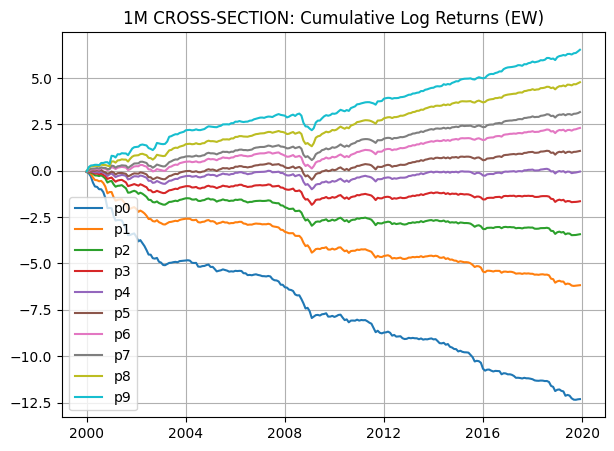

In [12]:
plot_deciles(ports_ew, f"{TYPE.upper()}: Cumulative Log Returns (EW)")

In [20]:
ports_ew = ports_ew.with_columns(
    (pl.col('p9')-pl.col('p0')).alias('spread')
)

In [23]:
from dotenv import load_dotenv
import os 

load_dotenv()

tmp = os.getenv('TMP')
ports_ew.write_parquet(f'{tmp}/deciles.parquet')

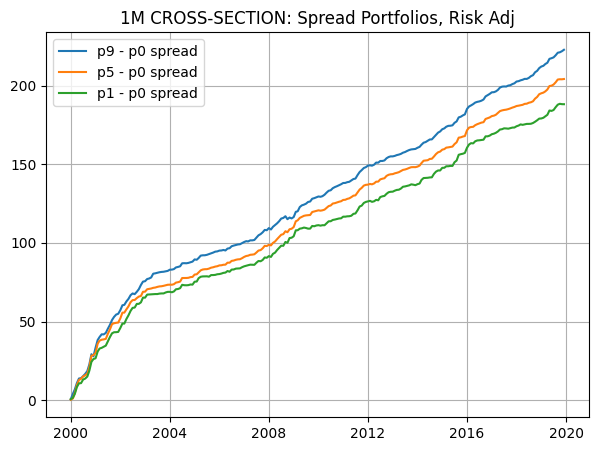

In [ ]:
dates = ports_ew['month']

plt.figure(figsize=(7, 5))
plt.title(f'{TYPE.upper()}: Spread Portfolios, Risk Adj')

plt.grid(True)

s9 = (ports_ew['p9'] - ports_ew['p0'])

plt.plot(dates, s9.cum_sum()/s9.std(), label='p9 - p0 spread')
plt.legend()


plt.show()

In [10]:
def Sharpe(df, name):
    annual_ret =  df.mean() * 12
    annual_vol = (df).std() * np.sqrt(12)
    sharpe = annual_ret / annual_vol

    print(
        f'{name}: \n'
        f'  Annual Return: {annual_ret:.2f} | '
        f'Annual Vol: {annual_vol:.2f} | '
        f'Sharpe: {sharpe:.2f}'
    )

Sharpe(s9, 'Spread 9')
Sharpe(s5, 'Spread 5')
Sharpe(s1, 'Spread 1')

Spread 9: 
  Annual Return: 0.94 | Annual Vol: 0.29 | Sharpe: 3.21
Spread 5: 
  Annual Return: 0.67 | Annual Vol: 0.23 | Sharpe: 2.95
Spread 1: 
  Annual Return: 0.31 | Annual Vol: 0.11 | Sharpe: 2.72


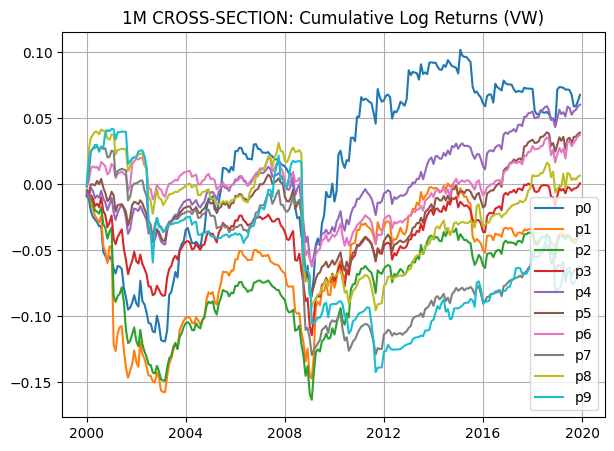

In [13]:
plot_deciles(ports_vw, f"{TYPE.upper()}: Cumulative Log Returns (VW)")

In [15]:
mes = (binned
.pivot(on='bin', index='month', values='market_cap')
.drop_nulls()
)

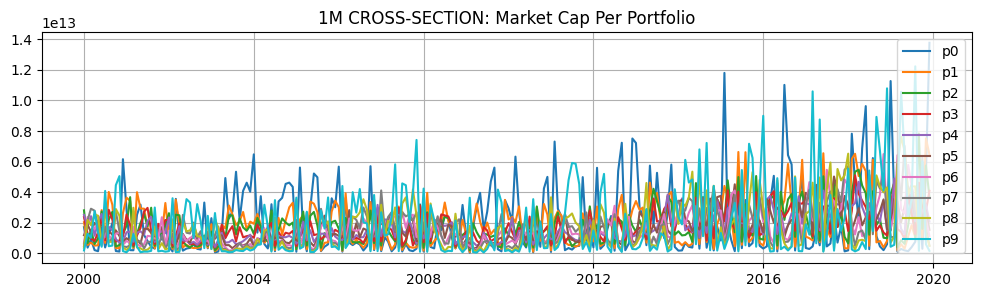

In [16]:
plot_deciles(mes, f'{TYPE.upper()}: Market Cap Per Portfolio', False, True)

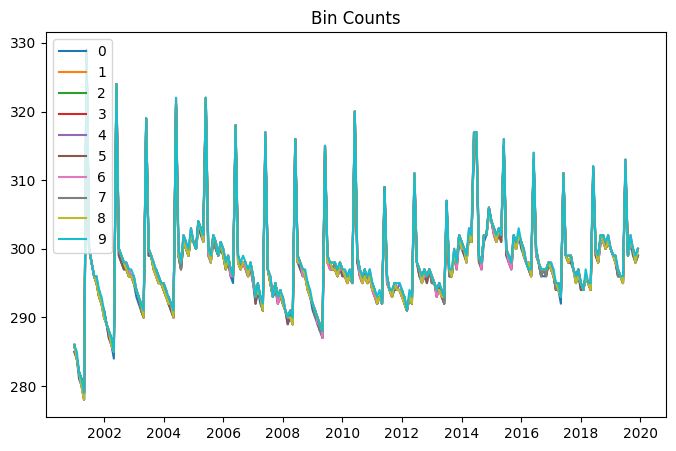

In [90]:
dates = ports_vw['month']
counts = (binned.pivot(
    on='bin', index='month', values='count'
)
)

plt.figure(figsize=(8, 5))
plt.title("Bin Counts")

for i in range(10):
    plt.plot(dates, counts[f'p{i}'], label = f'{i}')

plt.legend()
plt.show()

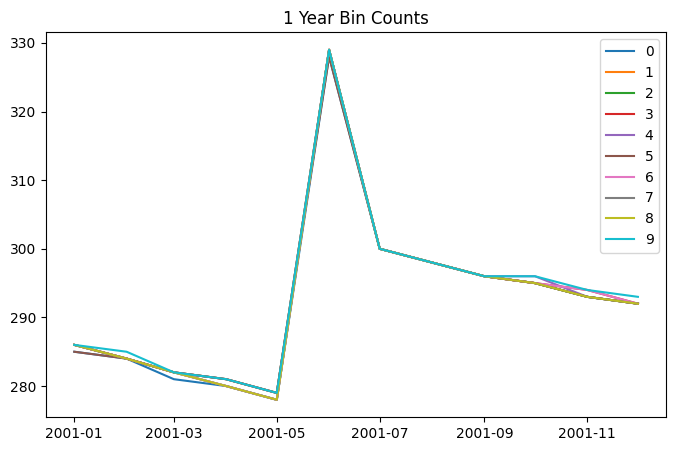

In [91]:
plt.figure(figsize=(8, 5))
plt.title("1 Year Bin Counts")

for i in range(10):
    plt.plot(dates[:12], counts[f'p{i}'][:12], label = f'{i}')

plt.legend()
plt.show()